# Kalman Filter - Modelling of COVID-19  (UNDER DEVELOPMENT)

**Authors:** J.H. Cao 
<br>
**Supervisors:** prof.dr.ir. N.A.W. van Riel, dr. D. Bosnacki
<br>
**Deparment:** Biomedical Engineering, Computational Biology Group at Eindhoven University of Technology

This notebook contain the codes to model and simulate an epidemic. The focus is on **a Kalman Filter** and can be used as a filter to predict new cases in the future. 


**_More info to be added_**

## Imports

### Packages

This section is for the import of the important python packages needed to develop the Kalman Filter.

In [412]:
%matplotlib inline 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit # This package is necessary for the logistic growth curve fit 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

### Data - Number of recorded cases in the Netherlands

This section is for the import of the data regarding the number of recorded cases of COVID-19 in the Netherlands

In [230]:
# The newest file containing the number of (+) cases in the Netherlands

covid19_NL_file = './data/rivm_corona_in_nl_daily.txt'

df_covid =  pd.read_csv(covid19_NL_file, parse_dates=['Datum']).set_index("Datum")

df_covid.head()

,Aantal
Datum,
2020-02-27,1
2020-02-28,2
2020-02-29,7
2020-03-01,10
2020-03-02,18


## Logistic Growth (3 parameters, Verhulst) - Number of Recorded Cases

In [231]:
# Adding a column of timestep for the curve_fit to the dataframe

df_covid['Timestep'] = [timestep for timestep in range(0, len(df_covid))]


# Re-arrange the columns 

cols = df_covid.columns.to_list()
cols = cols[1:] + cols[:-1]

df_covid = df_covid[cols]
df_covid.head()

,Timestep,Aantal
Datum,,
2020-02-27,0,1
2020-02-28,1,2
2020-02-29,2,7
2020-03-01,3,10
2020-03-02,4,18


In [232]:
# Changing the column name from dutch to english

df_covid = df_covid.rename(columns={"Aantal":"Total Cases"})
df_covid.head()

,Timestep,Total Cases
Datum,,
2020-02-27,0,1
2020-02-28,1,2
2020-02-29,2,7
2020-03-01,3,10
2020-03-02,4,18


In [410]:
df_covid['New Cases'] = df_covid[['Total Cases']].diff()
df_covid['New Cases'].iloc[0] = 0
df_covid.head()

,Timestep,Total Cases,New Cases
Datum,,,
2020-02-27,0,1,0.0
2020-02-28,1,2,1.0
2020-02-29,2,7,5.0
2020-03-01,3,10,3.0
2020-03-02,4,18,8.0


In [234]:
# Defining the logistic growth function with 3 parameters (Verhulst) for the population growth

# a = alpha (number of days at which the expected numer of cases is half the maximum)
# b = Beta (growth paramter / factor)
# c = M (expected maximum)
# t = time in days 

def logistic_growth(t, a, b, c):
    E = c / (1 + np.exp(-b * (t - a)))
    return E
    
# Obtaining the x and y data

x = np.array(df_covid['Timestep'])
y = np.array(df_covid['Total Cases'])

# Random initiazation of parameters and upper bound limit 

p0 = np.random.exponential(size = 3)

bounds = (0, [10000, 3, 17000000]) # upper bounds for the given parameters (alpha, beta, M)

In [235]:
# Fitting the logistic growth fucntion and defining the prediction function

(alpha, beta, M), logistic_cov = curve_fit(logistic_growth, x, y, bounds=bounds, p0=p0)

def logistic_pred(t):
    E = M / (1 + np.exp(-beta * (t - alpha)))
    return E

#### The estimated parameters and statistics:

In [236]:
def r_squared_logistic():
    residuals = y - logistic_pred(x)
    ss_res = np.sum(residuals**2)

    ss_tot = np.sum((y - np.mean(y))**2)

    R_squared = 1 - (ss_res / ss_tot)
    
    return R_squared

In [237]:
def prt_results_logistic():
    logistic_line = '%5s  %16s  %15s' % ("alpha = ", "beta = ", "M = ")
    logistic_params = '%5s  %14s  %14s' % (alpha, beta, M)

    print("**The estimated logistic growth parameters are:**")
    print()
    print(logistic_line)
    print(logistic_params)

    print()
    
    r2line = "%5s" % ("R^2 = ")
    r2_val = "%12s" % (r_squared_logistic())
    
    print("**The R^2 value for this logistic growth model is:**")
    print()
    print(r2line)
    print(r2_val)
    print()

#### Plotting the results:

In [238]:
max_cases = []

for i in x:
    max_cases.append(M)
predicted_max = np.array(max_cases)

**The estimated logistic growth parameters are:**

alpha =            beta =              M = 
41.15221468186354  0.11943094765045285  42000.47541754276

**The R^2 value for this logistic growth model is:**

R^2 = 
0.9978831378491106



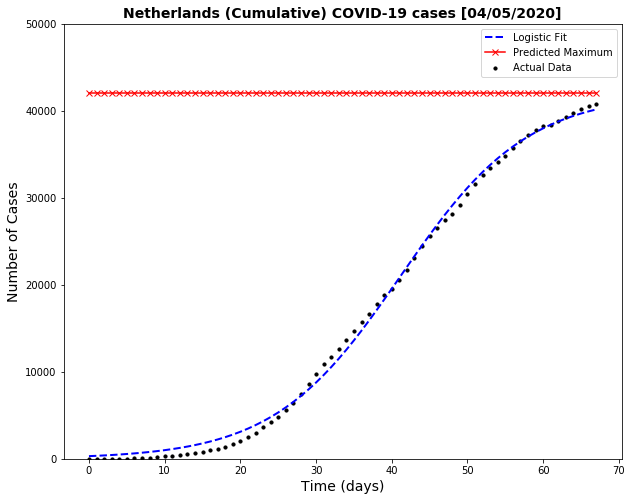

In [239]:
plt.figure(figsize=(10,8))

plt.scatter(x, y, s=10, marker='o', c='k')
plt.plot(x, logistic_pred(x), '--', lw=2, c='blue')
plt.plot(x, predicted_max, '-x', c='r')
plt.legend(['Logistic Fit', 'Predicted Maximum', 'Actual Data' ])
plt.ylim([0, 50000])

plt.title("Netherlands (Cumulative) COVID-19 cases [04/05/2020]", Fontsize = 14, weight='bold')
plt.xlabel("Time (days)", Fontsize = 14)
plt.ylabel("Number of Cases", Fontsize = 14);



prt_results_logistic() # Uncomment for statistics

<br>

## Kalman Filter - Applied on the daily confirmed cases

#### Prediction Algorithm 

In [335]:
def kf_predict(X, P, F, Q, B, U):
    X = np.dot(F, X) + np.dot(B, U)
    P = np.dot(F, np.dot(P, F.T)) + Q
    return (X, P)

#### Update 

In [336]:
def kf_update(X, P, Y, H, R):
    
    IM = np.dot(H, X)
    IS = R + np.dot(H, np.dot(P, H.T))
    
    K = np.dot(P, np.dot(H.T, np.linalg.inv(IS)))
    X = X + np.dot(K, (Y-IM))
    P = P - np.dot(K, np.dot(H, P))
    
    
    LH = gauss_pdf(Y, IM, IS)
    
    return (X, P, K, IM, IS, LH)

#### Gauss probability density function 

In [337]:
def gauss_pdf(X, M, S):
    
    if M.shape[1] == 1:
        DX = X - np.tile(M, X.shape[1])
        E = 0.5 * np.sum(DX * (np.dot(np.linalg.inv(S), DX)), axis=0)
        E = E + 0.5 * M.shape[0] * np.log(2 * np.pi) + 0.5 * np.log(np.linalg.det(S))
        P = np.exp(-E)
    
    elif X.shape[1] == 1:
        DX = np.tile(X, M.shape[1])- M
        E = 0.5 * np.sum(DX * (np.dot(np.linalg.inv(S), DX)), axis=0)
        E = E + 0.5 * M.shape[0] * np.log(2 * pi) + 0.5 * np.log(np.linalg.det(S))
        P = np.exp(-E)
    
    else:
        DX = X-M
        E = 0.5 * np.dot(DX.T, np.dot(np.linalg.inv(S), DX))
        E = E + 0.5 * M.shape[0] * np.log(2 * np.pi) + 0.5 * np.log(np.linalg.det(S))
        P = np.exp(-E)
    
    return (P[0],E[0]) 

#### Prediction and Filtering

In [579]:
#time step in days 
dt = 1


# Initialization of state matrices
X = np.array([[0], [0]])
P = np.diag((1e6, 1e6))  #  high variance
F = np.array([[1, dt], [0, 1]])
Q = np.eye(X.shape[0])
B = np.eye(X.shape[0])
U = np.zeros((X.shape[0],1)) 

In [580]:
# Measurement matrices
Y = np.array([[y[0]], [1]])
H = np.array([[1, 0], [0, 1]])
R = np.diag((0.01, 0.01))

In [581]:
# Applying the Kalman Filter
pred_kf = []
N_iter = len(y)
for i in np.arange(0, N_iter):
    
    (X, P) = kf_predict(X, P, F, Q, B, U)
    (X, P, K, IM, IS, LH) = kf_update(X, P, Y, H, R)
    Y = np.array([[y[i]],[x[i]]]) 
    pred_kf.append(X[0,0])
    

#### Plot results for comparison

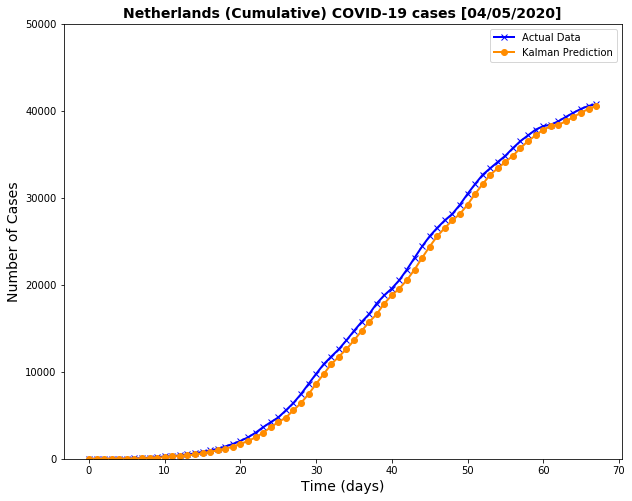

In [582]:
plt.figure(figsize=(10,8))

plt.plot(x, y,"-x",lw=2, c='blue')
plt.plot(x, pred_kf, '-o', lw=2, c='darkorange')


plt.legend(['Actual Data','Kalman Prediction'])
plt.ylim([0, 50000])

plt.title("Netherlands (Cumulative) COVID-19 cases [04/05/2020]", Fontsize = 14, weight='bold')
plt.xlabel("Time (days)", Fontsize = 14)
plt.ylabel("Number of Cases", Fontsize = 14);
